# HTRF analysis and hit selection

In [3]:
# import mysql.connector
import pandas as pd
import os
import sys
import numpy as np
pd.set_option('display.max_columns', 90)
from pathlib import Path, PureWindowsPath

import importlib
sys.path.append('/home/apaulson/repos/data-proc/')
import plate_maps as pm
%config Completer.use_jedi=False

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_venn as mpv

colors = ["#6EC8BE","#BE2369","#FFC30F","#694691","#EB1E23","#7682A4","#373C50","#A7DDD8",]
sns.set_palette(colors)
sns.set_context('notebook')

## Load data downloaded from HiTS
- remove spaces in column names
- remove control & empty wells

In [15]:
# fulldat=r"Z:\SMDC\Screens\2020 Screens\2020-04_Project 270_TAR HIV_Ott (Gladstone)\Analysis\20230112_ChemDiv_Nucleoside_Analysis_AKP\TAR-Tat HIV-Nucleoside_all_data.csv"
# fulldat=fulldat.replace("\\","/").replace('Z:','/mnt/z')
# print(fulldat)
fulldat='./TAR-Tat HIV-TAR-Tat HIV-HTRF-20220125-112733-20220125-150853.csv'
nuc=pd.read_csv(fulldat, skiprows=1)
nuc.columns=[x.replace(' ','_') for x in nuc.columns]
nuc=nuc[~nuc.Compound.isna()]
nuc=nuc.sort_values('Well')
nuc.shape

(3777, 35)

In [16]:
# fulldat=r"Z:\SMDC\Screens\2020 Screens\2020-04_Project 270_TAR HIV_Ott (Gladstone)\Analysis\20230112_ChemDiv_Nucleoside_Analysis_AKP\TAR-Tat HIV-Counter_all_data.csv"
# fulldat=fulldat.replace("\\","/").replace('Z:','/mnt/z')
# print(fulldat)

cou=pd.read_csv(fulldat, skiprows=1)
cou.columns=[x.replace(' ','_') for x in cou.columns]
cou=cou[~cou.Compound.isna()]
cou=cou.sort_values('Well')
cou.shape

(3777, 35)

In [17]:
nuc['Plate_Well']=nuc.Plate+'_'+nuc.Well
cou['Plate_Well']=cou.Plate+'_'+cou.Well

## Filter data by poor donor signal - nucleoside

In [299]:
nucdonormean=nuc.fretdonor.mean()
nucdonorstd=nuc.fretdonor.std()
nucdonorcoff=nucdonormean+nucdonorstd

In [300]:
nuc.Well_Type.value_counts()

compound    1258
Name: Well_Type, dtype: int64

/home/apaulson/miniconda3/envs/new-pandas/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/home/apaulson/miniconda3/envs/new-pandas/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0.5, 0.93, 'Raw donor signal of Nucleoside compound wells\nwith 1 standard deviation above the mean marked')

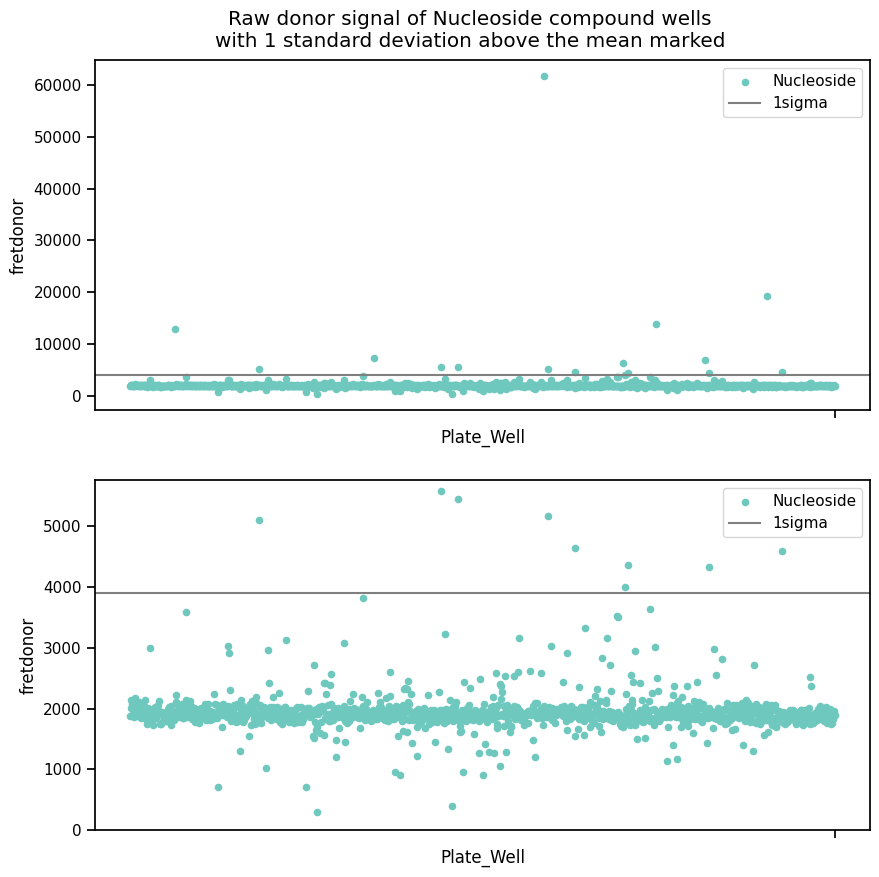

In [301]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
nuc.plot(x='Plate_Well',y='fretdonor', kind='scatter', ax=ax[0], label='Nucleoside')
nuc.plot(x='Plate_Well',y='fretdonor', kind='scatter', ax=ax[1], label='Nucleoside')
ax[1].set_ylim(0, nucdonorcoff+nucdonorstd)
ax[1].axhline(nucdonorcoff, c='gray', label='1sigma')
ax[0].axhline(nucdonorcoff, c='gray', label='1sigma')
ax[0].set_xticks([''])
ax[1].set_xticks([''])
ax[0].legend()
ax[1].legend()
fig.suptitle('Raw donor signal of Nucleoside compound wells\nwith 1 standard deviation above the mean marked', x=0.5, y=0.93)

In [302]:
print('all',nuc.shape)
nucnix=nuc[nuc.fretdonor>=nucdonorcoff]
print('nix', nucnix.shape)
nuc=nuc[nuc.fretdonor<nucdonorcoff]
print('all',nuc.shape)

all (1258, 36)
nix (16, 36)
all (1242, 36)


/home/apaulson/miniconda3/envs/new-pandas/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0.5, 0.97, 'Filtered raw donor signal of Nucleoside compound wells\nwith 1 standard deviation above the mean marked')

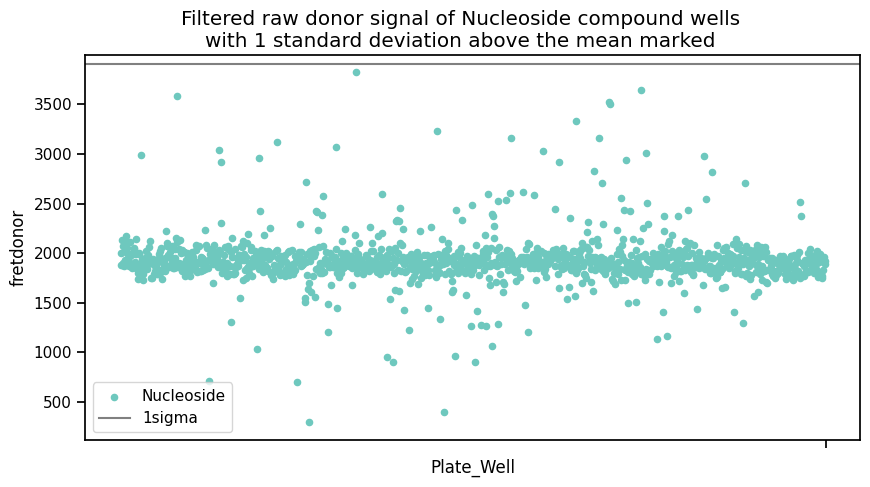

In [303]:
fig, ax =plt.subplots(1, figsize=(10,5))
nuc[nuc.Well_Type=='compound'].plot(x='Plate_Well',y='fretdonor', kind='scatter', ax=ax, label='Nucleoside')
ax.axhline(nucdonorcoff, c='gray', label='1sigma')
ax.set_xticks([''])
ax.legend()
fig.suptitle('Filtered raw donor signal of Nucleoside compound wells\nwith 1 standard deviation above the mean marked', x=0.5, y=0.97)

## Filter compounds by poor donor signal - counter

In [304]:
coudonormean=cou.fretdonor.mean()
coudonorstd=cou.fretdonor.std()
coudonorcoff=coudonormean+coudonorstd

/home/apaulson/miniconda3/envs/new-pandas/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/home/apaulson/miniconda3/envs/new-pandas/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0.5, 0.93, 'Raw donor signal of Counter compound wells\nwith 1 standard deviation above the mean marked')

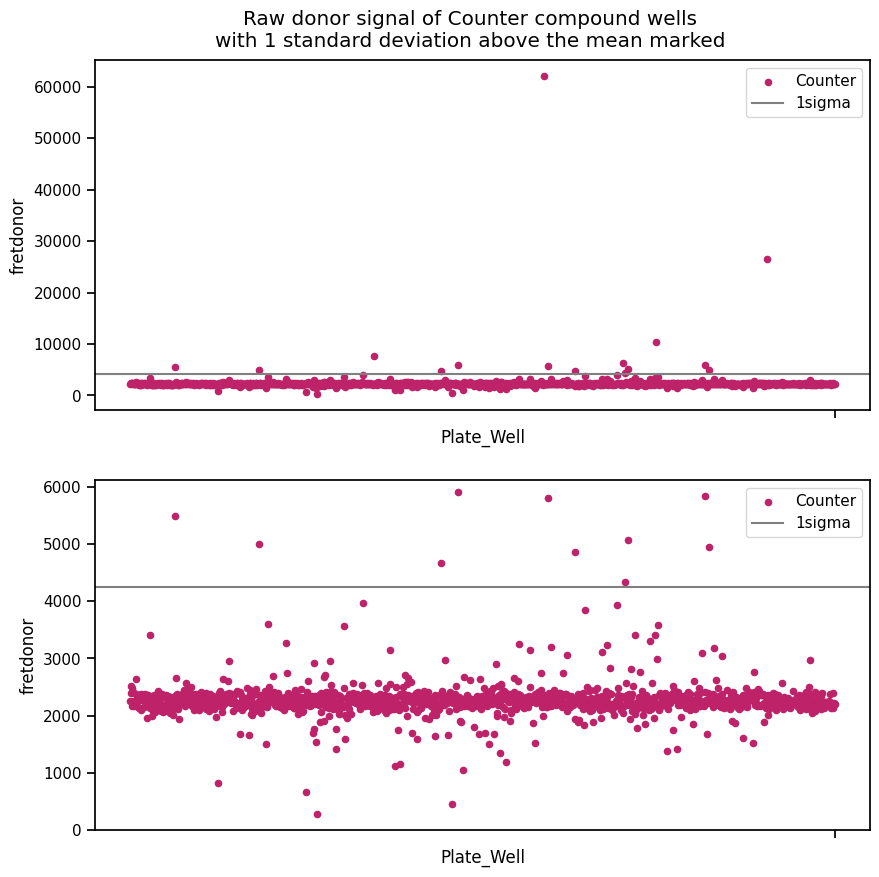

In [305]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
cou.plot(x='Plate_Well',y='fretdonor', kind='scatter', ax=ax[0], c=colors[1], label='Counter')
cou.plot(x='Plate_Well',y='fretdonor', kind='scatter', ax=ax[1], c=colors[1], label='Counter')
ax[1].set_ylim(0, coudonorcoff+coudonorstd)
ax[1].axhline(coudonorcoff, c='gray', label='1sigma')
ax[0].axhline(coudonorcoff, c='gray', label='1sigma')
ax[0].set_xticks([''])
ax[1].set_xticks([''])
ax[0].legend()
ax[1].legend()
fig.suptitle('Raw donor signal of Counter compound wells\nwith 1 standard deviation above the mean marked', x=0.5, y=0.93)

In [306]:
print('all',cou.shape)
counix=cou[cou.fretdonor>=coudonorcoff]
cou=cou[cou.fretdonor<coudonorcoff]
print('nix',counix.shape)
print('all',cou.shape)

all (1258, 36)
nix (15, 36)
all (1243, 36)


/home/apaulson/miniconda3/envs/new-pandas/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0.5, 0.97, 'Filtered raw donor signal of Counter compound wells\nwith 1 standard deviation above the mean marked')

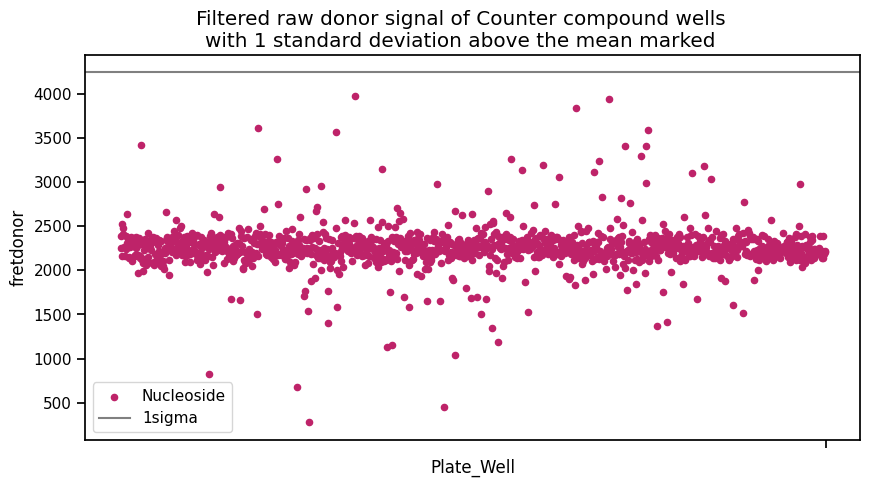

In [308]:
fig, ax =plt.subplots(1, figsize=(10,5))
cou[cou.Well_Type=='compound'].plot(x='Plate_Well',y='fretdonor', kind='scatter', ax=ax, c=colors[1], label='Nucleoside')
ax.axhline(coudonorcoff, c='gray', label='1sigma')
ax.set_xticks([''])
ax.legend()
fig.suptitle('Filtered raw donor signal of Counter compound wells\nwith 1 standard deviation above the mean marked', x=0.5, y=0.97)

## Compare donor signal-filtered compounds between nucleoside and counter screens

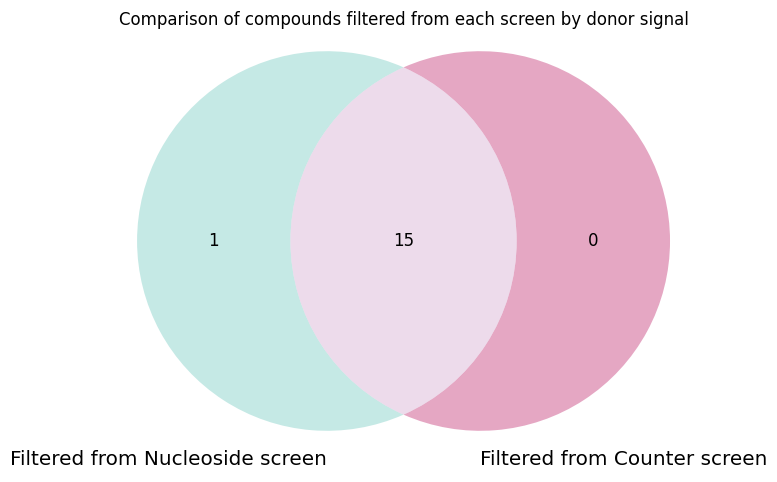

In [316]:
counixcpd=set(counix.Compound)
nucnixcpd=set(nucnix.Compound)
fig, ax = plt.subplots(1, figsize=(10,6))
mpv.venn2_unweighted([nucnixcpd,counixcpd], set_labels=['Filtered from Nucleoside screen','Filtered from Counter screen'], set_colors=colors[0:2], ax=ax)
ax.set_title('Comparison of compounds filtered from each screen by donor signal', x=0.5, y=0.95);

## Select hits after filtering out bad donor signal compounds - nucleoside
- fretratio_inhibition >3SD
- fretratio_inhibition_bscore >3SD

In [18]:
nucinhibmean=nuc[nuc.Well_Type=='compound'].fretratio_inhibition.mean()
nucinhibstd=nuc[nuc.Well_Type=='compound'].fretratio_inhibition.std()
nucinhibcoff=nucinhibmean+3*nucinhibstd

In [22]:
nuc=nuc.reset_index(drop=True).reset_index()
nuc.Compound=nuc.Compound.astype(int).astype(str)

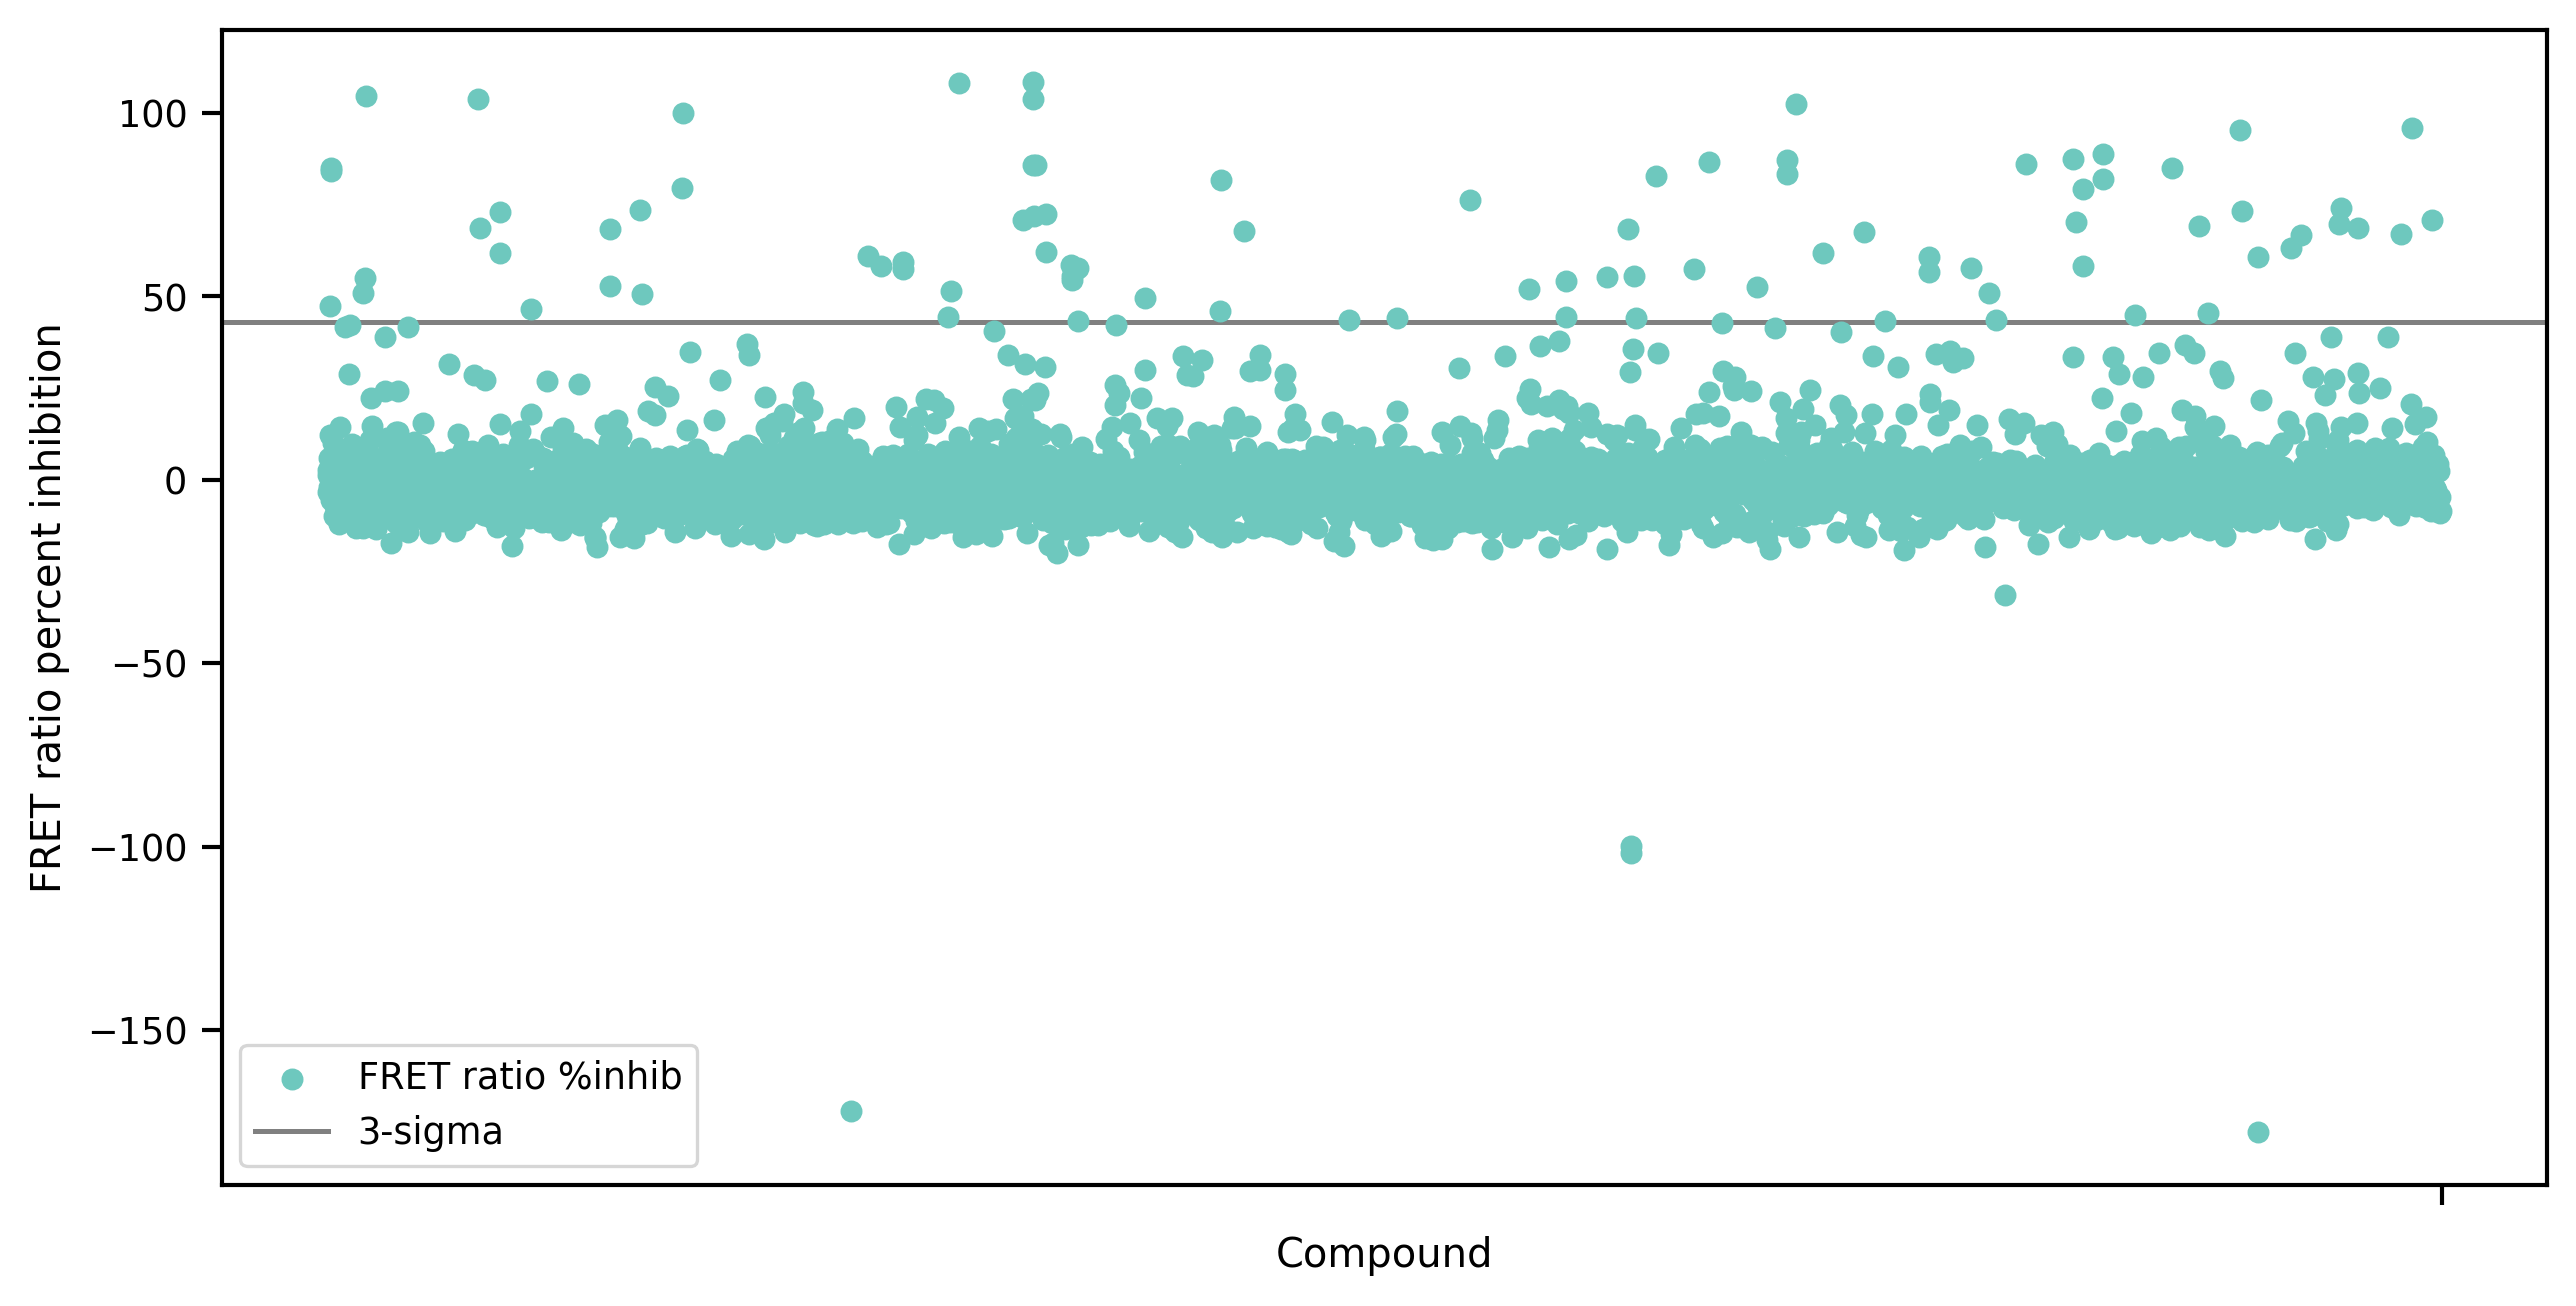

In [32]:
sns.set_context('paper')
fig, ax =plt.subplots(1, figsize=(10,5), dpi=300)
nuc[nuc.Well_Type=='compound'].plot(x='Compound',y='fretratio_inhibition', kind='scatter', ax=ax, 
                                    label='FRET ratio %inhib'
                                   )
ax.axhline(nucinhibcoff, c='gray', label='3-sigma', zorder=0)
ax.set_xticks([''])
ax.set_ylabel('FRET ratio percent inhibition')
# ax.set_ylim(-25,125)
ax.legend()
# ax.set_title('FRET ratio inhibition of compound wells\nmarked at 3 standard deviations above the mean');

In [324]:
nucinhibhits=nuc[(nuc.Well_Type=='compound') & (nuc.fretratio_inhibition>=nucinhibcoff)]
nucinhibhits.shape

(29, 36)

/home/apaulson/miniconda3/envs/new-pandas/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


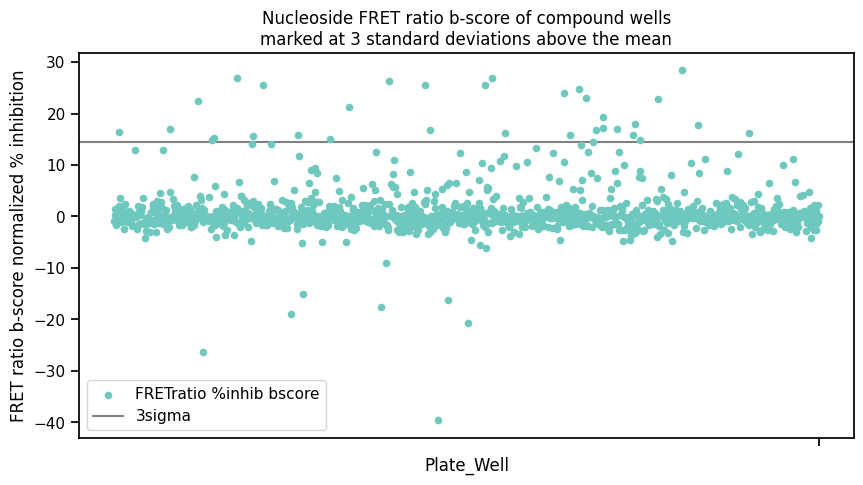

In [345]:
nucinhibmean=nuc[nuc.Well_Type=='compound']['fretratio_b-score'].mean()
nucinhibstd=nuc[nuc.Well_Type=='compound']['fretratio_b-score'].std()
nucinhibcoff=nucinhibmean+3*nucinhibstd

fig, ax =plt.subplots(1, figsize=(10,5))
nuc[nuc.Well_Type=='compound'].plot(x='Plate_Well',y='fretratio_b-score', kind='scatter', ax=ax, label='FRETratio %inhib bscore')
ax.axhline(nucinhibcoff, c='gray', label='3sigma', zorder=0)
ax.set_xticks([''])
ax.set_ylabel('FRET ratio b-score normalized % inhibition')
ax.legend()
ax.set_title('Nucleoside FRET ratio b-score of compound wells\nmarked at 3 standard deviations above the mean');

In [328]:
nucbscorehits=nuc[(nuc.Well_Type=='compound') & (nuc['fretratio_b-score']>=nucinhibcoff)]
nucbscorehits.shape

(33, 36)

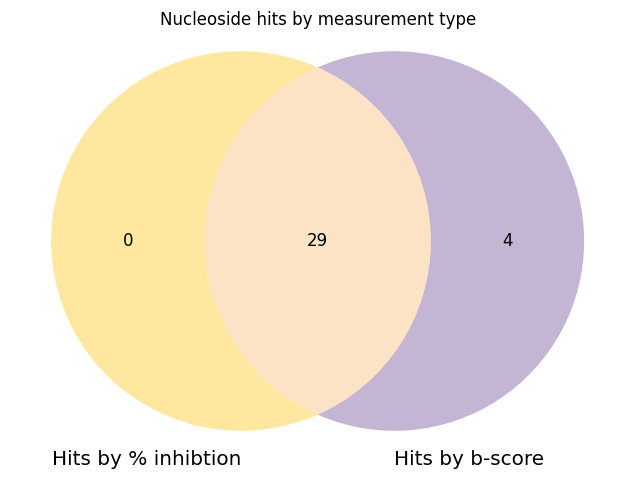

In [331]:
nucinhibhitscpd=set(nucinhibhits.Compound)
nucbscorehitscpd=set(nucbscorehits.Compound)
fig, ax = plt.subplots(1, figsize=(10,6))
mpv.venn2_unweighted([nucinhibhitscpd,nucbscorehitscpd], set_labels=['Hits by % inhibtion','Hits by b-score'], ax=ax, set_colors=colors[2:4])
ax.set_title('Nucleoside hits by measurement type', y=0.95);

## Select hits after filtering out bad donor signal compounds - counter
- fretratio_inhibition >3SD
- fretratio_inhibition_bscore >3SD

/home/apaulson/miniconda3/envs/new-pandas/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


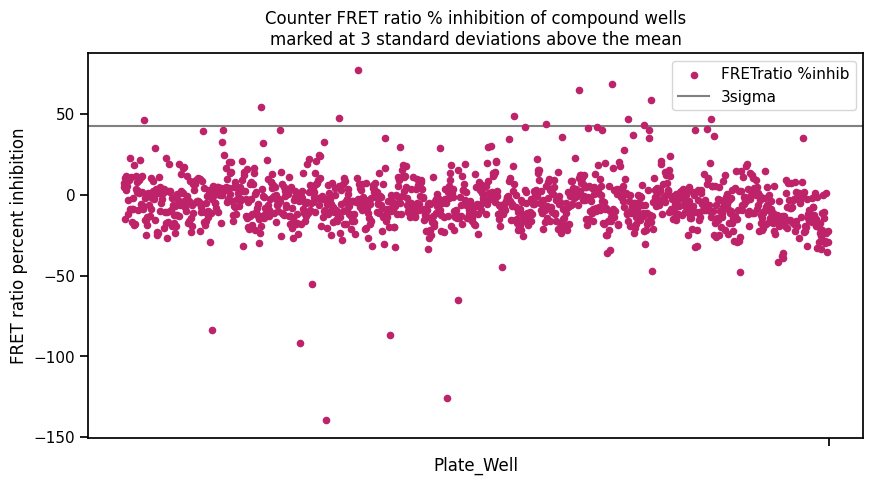

In [340]:
couinhibmean=cou[cou.Well_Type=='compound'].fretratio_inhibition.mean()
couinhibstd=cou[cou.Well_Type=='compound'].fretratio_inhibition.std()
couinhibcoff=couinhibmean+3*couinhibstd

fig, ax =plt.subplots(1, figsize=(10,5))
cou[cou.Well_Type=='compound'].plot(x='Plate_Well',y='fretratio_inhibition', kind='scatter', ax=ax, c=colors[1], label='FRETratio %inhib')
ax.axhline(couinhibcoff, c='gray', label='3sigma', zorder=0)
ax.set_xticks([''])
ax.set_ylabel('FRET ratio percent inhibition')
ax.legend()
ax.set_title('Counter FRET ratio % inhibition of compound wells\nmarked at 3 standard deviations above the mean');

In [341]:
couinhibhits=cou[(cou.Well_Type=='compound') & (cou.fretratio_inhibition>=couinhibcoff)]
couinhibhits.shape

(12, 36)

/home/apaulson/miniconda3/envs/new-pandas/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


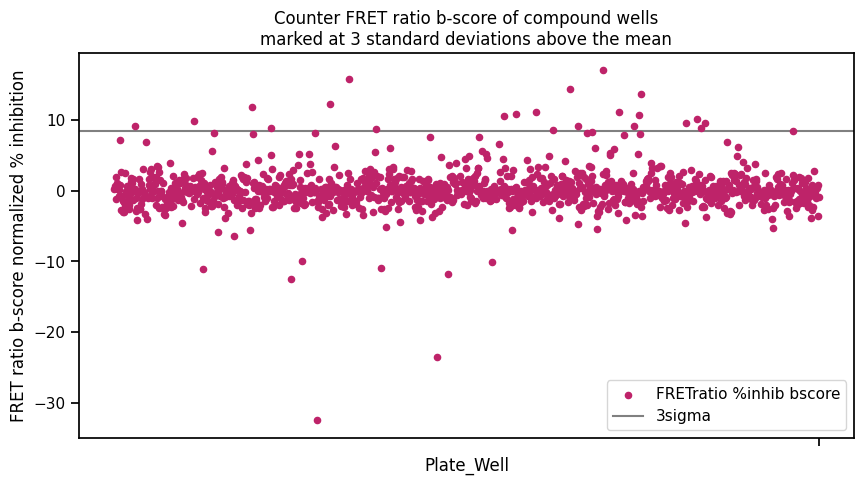

In [344]:
couinhibmean=cou[cou.Well_Type=='compound']['fretratio_b-score'].mean()
couinhibstd=cou[cou.Well_Type=='compound']['fretratio_b-score'].std()
couinhibcoff=couinhibmean+3*couinhibstd

fig, ax =plt.subplots(1, figsize=(10,5))
cou[cou.Well_Type=='compound'].plot(x='Plate_Well',y='fretratio_b-score', kind='scatter', ax=ax, c=colors[1], label='FRETratio %inhib bscore')
ax.axhline(couinhibcoff, c='gray', label='3sigma', zorder=0)
ax.set_xticks([''])
ax.set_ylabel('FRET ratio b-score normalized % inhibition')
ax.legend()
ax.set_title('Counter FRET ratio b-score of compound wells\nmarked at 3 standard deviations above the mean');

In [346]:
coubscorehits=cou[(cou.Well_Type=='compound') & (cou['fretratio_b-score']>=couinhibcoff)]
coubscorehits.shape

(22, 36)

Text(0.5, 0.95, 'Counter hits by measurement type')

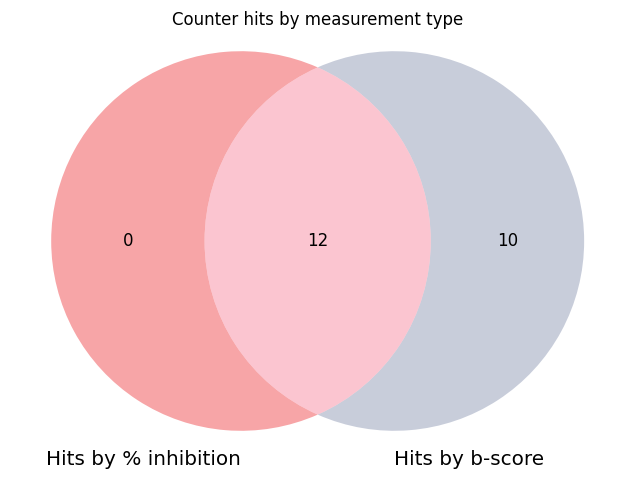

In [351]:
couinhibhitscpd=set(couinhibhits.Compound)
coubscorehitscpd=set(coubscorehits.Compound)
fig, ax = plt.subplots(1, figsize=(10,6))
mpv.venn2_unweighted([couinhibhitscpd,coubscorehitscpd], set_labels=['Hits by % inhibition','Hits by b-score'], ax=ax, set_colors=colors[4:6])
ax.set_title('Counter hits by measurement type', y=0.95)

## Compare hits from Counter and Nucleoside final hits

Text(0.5, 0.95, 'Compare Nucleoside and Counter hits from b-score data')

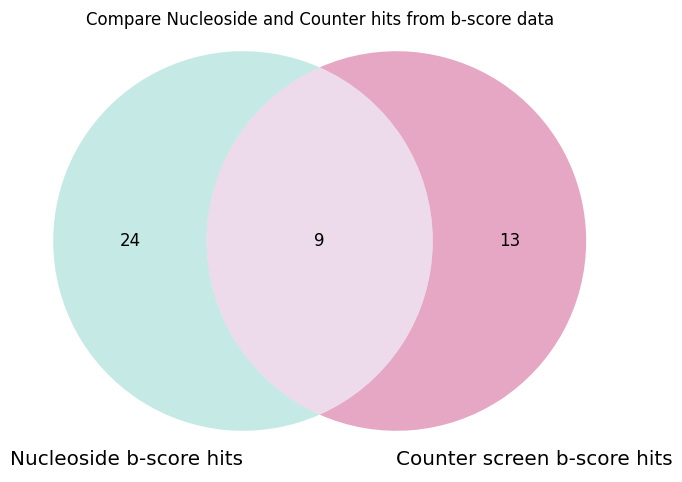

In [355]:
fig, ax = plt.subplots(1, figsize=(10,6))
mpv.venn2_unweighted([nucbscorehitscpd,coubscorehitscpd], set_labels=['Nucleoside b-score hits','Counter screen b-score hits'], ax=ax, set_colors=colors[0:2])
ax.set_title('Compare Nucleoside and Counter hits from b-score data', y=0.95)

Text(0.5, 0.95, 'Compare Nucleoside and Counter hits from %inhibition data')

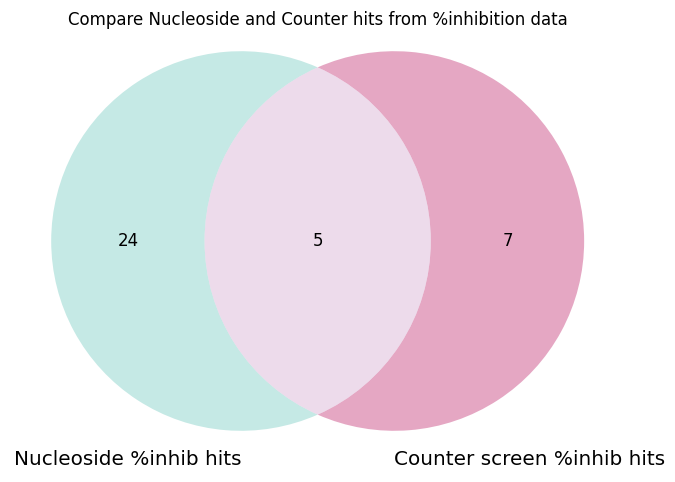

In [356]:
fig, ax = plt.subplots(1, figsize=(10,6))
mpv.venn2_unweighted([nucinhibhitscpd,couinhibhitscpd], set_labels=['Nucleoside %inhib hits','Counter screen %inhib hits'], ax=ax, set_colors=colors[0:2])
ax.set_title('Compare Nucleoside and Counter hits from %inhibition data', y=0.95)

## Select Nucleoside hits that are not counter hits

In [361]:
nucbselecthitscpd=nucbscorehitscpd-coubscorehitscpd
len(nucbselecthitscpd)

24

In [358]:
nuciselecthitscpd=nucinhibhitscpd-couinhibhitscpd
len(nuciselecthitscpd)

24

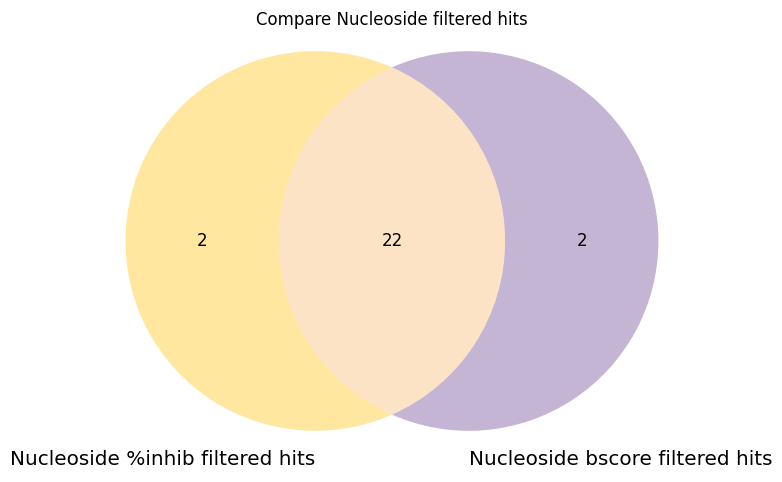

In [363]:
fig, ax = plt.subplots(1, figsize=(10,6))
mpv.venn2_unweighted([nuciselecthitscpd,nucbselecthitscpd], set_labels=['Nucleoside %inhib filtered hits','Nucleoside bscore filtered hits'], ax=ax, set_colors=colors[2:4])
ax.set_title('Compare Nucleoside filtered hits', y=0.95);

In [380]:
nucbselecthitscpd-nuciselecthitscpd

{1074552.0, 1075110.0}

In [369]:
allnuchitscpd=nuciselecthitscpd|nucbselecthitscpd

len(allnuchitscpd)

In [370]:
tarhits=nuc[nuc.Compound.isin(allnuchitscpd)]
tarhits.shape

(26, 36)

In [371]:
fulldat

'/mnt/z/SMDC/Screens/2020 Screens/2020-04_Project 270_TAR HIV_Ott (Gladstone)/Analysis/20230112_ChemDiv_Nucleoside_Analysis_AKP/TAR-Tat HIV-Counter_all_data.csv'

In [372]:
tarhits.to_csv('/mnt/z/SMDC/Screens/2020 Screens/2020-04_Project 270_TAR HIV_Ott (Gladstone)/Analysis/20230112_ChemDiv_Nucleoside_Analysis_AKP/TAR-Tat HIV-Nucleoside_filtered_hits.csv')

In [377]:
disp=tarhits[['Compound','Plate','Well','fretratio_inhibition','fretratio_b-score', 'fretdonor']]
disp.Compound=disp.Compound.astype(int)
disp

/tmp/ipykernel_589/3393264596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disp.Compound=disp.Compound.astype(int)


,Compound,Plate,Well,fretratio_inhibition,fretratio_b-score,fretdonor
4,1074400,CDI PLATE_001-IN1,A05,40.958174,16.505760,2173.0
799,805884,CDI PLATE_003-IN1,B08,43.951780,16.990870,3583.0
427,1074694,CDI PLATE_002-IN1,B20,56.641002,22.360583,2237.0
54,116050,CDI PLATE_001-IN1,C07,36.913658,14.944992,3038.0
438,1074552,CDI PLATE_002-IN1,C07,33.919029,15.326345,2918.0
64,1083968,CDI PLATE_001-IN1,C17,64.051810,26.920917,2120.0
460,1075247,CDI PLATE_002-IN1,D05,36.514687,15.620433,2423.0
81,55987,CDI PLATE_001-IN1,D10,60.201736,25.522077,2256.0
100,1074407,CDI PLATE_001-IN1,E05,37.972981,15.748846,1543.0
149,1074456,CDI PLATE_001-IN1,G06,66.897231,26.360908,2328.0


## Plate visualization

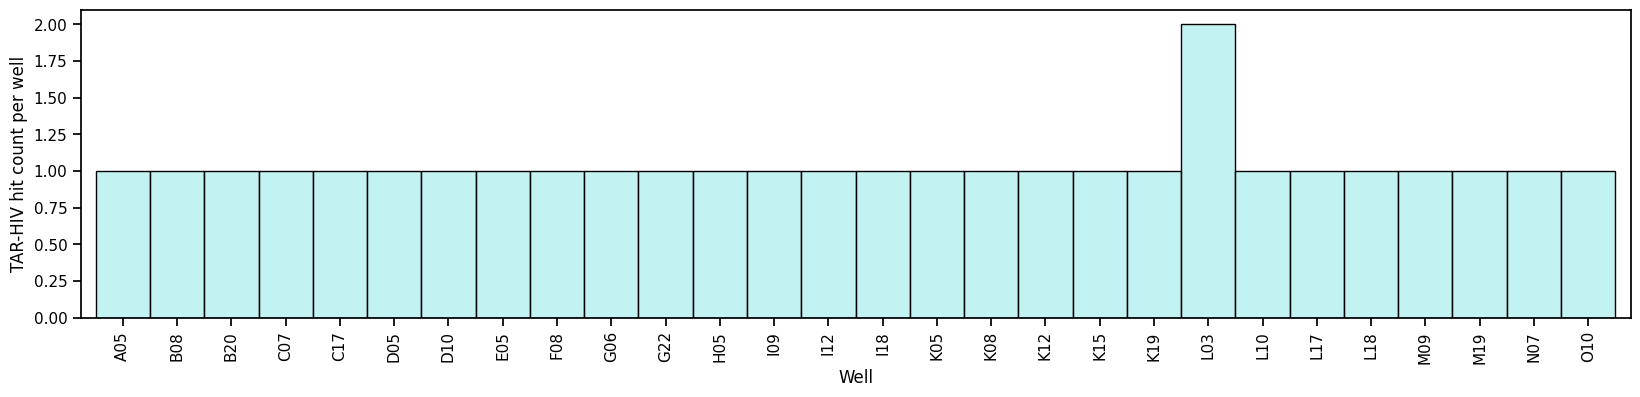

In [210]:
fig, ax = plt.subplots(1, figsize=(20,4))
sns.histplot(tarhits.Well, color='paleturquoise')
ax.tick_params(axis='x', rotation=90)
ax.margins(x=0.01)
ax.set_ylabel('TAR-HIV hit count per well');

In [211]:
nuc['Row']=nuc.Well[0]
nuc['Column']=nuc.Well[1:]

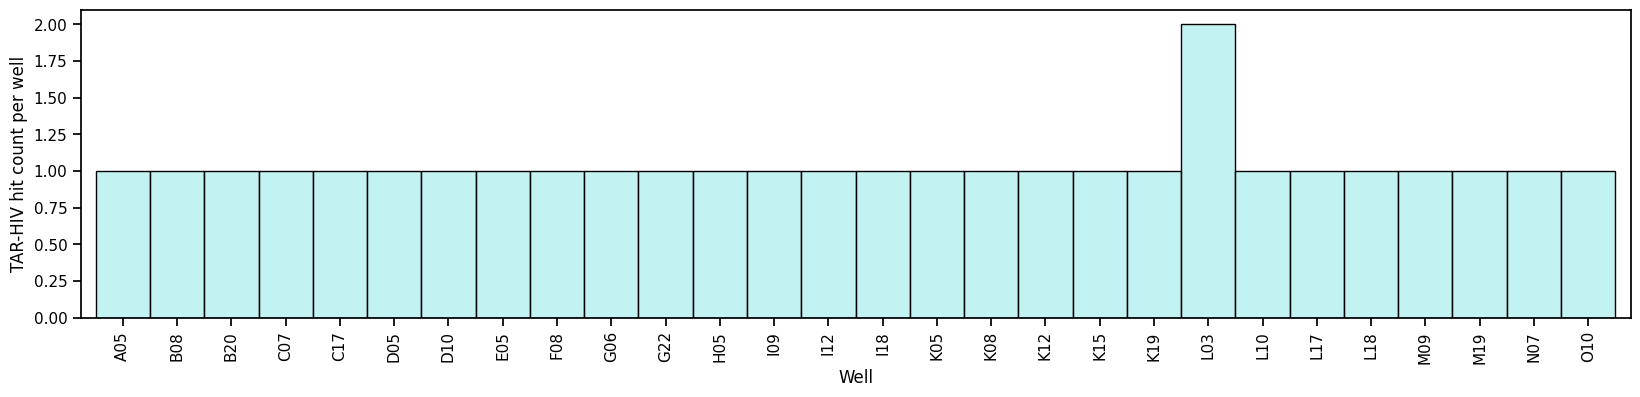

In [212]:
fig, ax = plt.subplots(1, figsize=(20,4))
sns.histplot(tarhits.Well, color='paleturquoise')
ax.tick_params(axis='x', rotation=90)
ax.margins(x=0.01)
ax.set_ylabel('TAR-HIV hit count per well');

In [213]:
nuc.columns

Index(['Compound', 'Alias', 'SMILES', 'Lot_#', 'Lot_Alias', 'Salt', 'Solvate',
       'Vendor', 'Library_Name', 'PAINS', 'Bruns-Watson_Demerit_Score',
       'Assay_Version', 'Plate', 'Plate_Z-prime', 'Plate_Z-factor', 'Plate_CV',
       'Repeat', 'Plate_Statistic_Result_Type', 'Well_Type', 'Well',
       'fretacceptor_b-score', 'fretdonor_b-score', 'fretratio_b-score',
       'fretacceptor_fold_change', 'fretdonor_fold_change',
       'fretratio_fold_change', 'fretacceptor', 'fretdonor', 'fretratio',
       'fretacceptor_inhibition', 'fretdonor_inhibition',
       'fretratio_inhibition', 'fretacceptor_standard_score',
       'fretdonor_standard_score', 'fretratio_standard_score', 'Plate_Well',
       'Row', 'Column'],
      dtype='object')

In [188]:
importlib.reload(pm)

<module 'plate_maps' from '/mnt/c/Users/akpau/Repos/data_proc/plate_maps.py'>

In [189]:
plates=nuc.Plate.unique().tolist()
for plate in plates:
    pm.draw_plate_heatmap(df=nuc[nuc.Plate==plate].copy(), wells='Well', 
                          labels='Compound',values='fretratio inhibition', 
                          barcode=plate, width=35,
                          vmin=0, vmax=100,
                          # outdir='./mers_plate_maps'
                         )

KeyError: 'fretratio inhibition'

## Hit Selection

    HTRF Ratio ≥3 SD 
    86/1536 compounds, 5.6% Initial hit rate.

    Filtered Hits: HTRF Ratio ≥ 3 SD & Donor signal ≤ 3 SD 
    82/1536 compounds, 5.3% Hit Rate

In [ ]:
tarhits.shape

In [ ]:
nuc.shape

In [ ]:
tarhits.SMILES.nunique()

In [73]:
86/1536*100

5.598958333333334

In [74]:
len(set(tarhits.SMILES.unique())-set(tardonor.SMILES.unique()))

82

In [75]:
82/1536*100

5.338541666666666

In [76]:
filtered=list(set(tarhits.SMILES)-set(tardonor.SMILES))
len(filtered)

82

In [77]:
tarhits_filt=tarhits[tarhits.SMILES.isin(filtered)]

## save

In [78]:
tarhits_filt.to_csv('/mnt/z/SMDC/Screens/2020 Screens/2020-04_Project 270_TAR HIV_Ott (Gladstone)/Analysis/20230112_ChemDiv_Nucleoside_Analysis_AKP/TAR-Tat HIV-TAR-Tat HIV-HTRF_Nucleoside-3sigma_inhibition_filtered.csv')

In [79]:
tarhits.to_csv('./tarhits.csv')
tarhits_filt.to_csv('./tarhits_filt.csv')
tardonor.to_csv('./tardonor.csv')
nuc.to_csv('./nuc.csv')

In [80]:
!pwd

/mnt/c/Users/akpau/Repos/Notebooks/SMDC_analyze_screen


## Why is donor inhibition so wild in % inhibition values

In [28]:
tarnona=nuc[~nuc.Compound.isna()]
tarnona.Compound=tarnona.Compound.astype(int).astype(str)
nuc.head(2)

/tmp/ipykernel_503/2380846482.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tarnona.Compound=tarnona.Compound.astype(int).astype(str)


,Compound,Alias,SMILES,Lot #,Lot Alias,Salt,Solvate,Vendor,Library Name,PAINS,Bruns-Watson Demerit Score,Assay Version,Plate,Plate Z-prime,Plate Z-factor,Plate CV,Repeat,Plate Statistic Result Type,Well Type,Well,fretacceptor b-score,fretdonor b-score,fretratio b-score,fretacceptor fold change,fretdonor fold change,fretratio fold change,fretacceptor,fretdonor,fretratio,fretacceptor inhibition,fretdonor inhibition,fretratio inhibition,fretacceptor standard score,fretdonor standard score,fretratio standard score
0,NaN,NaN,NaN,NaN,NaN,None,None,NaN,ChemDiv Nucleoside Mimetic,NaN,NaN,20221206,CDI PLATE_001-IN1,"0.863,0.572,0.823","0.22,-0.986,0.179","0.0448,0.0293,0.0576",1,"fretacceptor,fretdonor,fretratio",negativeControl,A01,NaN,NaN,NaN,0.996199,0.992113,1.002904,144059.0,1942.0,741807.4150,0.384470,2.250775,-0.295534,-0.453183,-0.360522,-0.136572
768,NaN,NaN,NaN,NaN,NaN,None,None,NaN,ChemDiv Nucleoside Mimetic,NaN,NaN,20221206,CDI PLATE_003-IN1,"0.967,0.603,0.928","0.328,-1.44,0.247","0.00858,0.0205,0.0207",1,"fretacceptor,fretdonor,fretratio",negativeControl,A01,NaN,NaN,NaN,0.985503,1.031126,0.955381,145950.0,2056.0,709873.5409,1.468076,-9.212357,4.547622,-0.211694,-0.051601,-0.065446


In [21]:
tarlong=tarnona.melt(id_vars='Compound', value_name='inhibition',value_vars=['fretacceptor','fretdonor','fretratio'])
tarlong.head(2)

/tmp/ipykernel_503/3581266343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tarnona.Compound=tarnona.Compound.astype(int).astype(str)


,Compound,variable,inhibition
0,182442,fretacceptor,146064.0
1,148139,fretacceptor,146546.0


/tmp/ipykernel_503/1025662054.py:2: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.scatterplot(tarlong, x='Compound',y='inhibition', hue='variable', palette = colors)


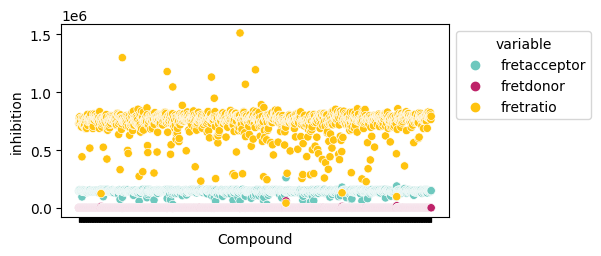

In [73]:
fig, ax = plt.subplots(1, figsize=(5,2.5))
sns.scatterplot(tarlong, x='Compound',y='inhibition', hue='variable', palette = colors)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.set_xticklabels('');

In [34]:
from pandas.api.types import CategoricalDtype

In [41]:
typecat=CategoricalDtype(['compound','positiveControl','negativeControl'], ordered=True)
nuc['Well Type']=nuc['Well Type'].astype(typecat)
nuc=nuc.sort_values('Well Type', ascending=True)

In [57]:
nuc=nuc.reset_index().rename(columns={'index':'compound_num'})

/tmp/ipykernel_503/2163595388.py:5: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(tarhiv, x='compound_num', y='fretdonor', hue='Well Type', palette=colors[3:])


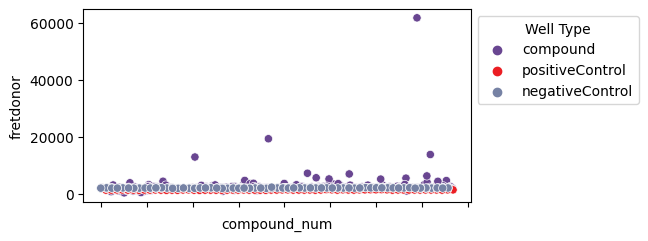

In [74]:
fig, ax = plt.subplots(1, figsize=(5,2.5))
# ax.scatter(data=nuc[nuc['Well Type']=='compound'], x='Compound', y='fretdonor', label='compound', zorder=0, s=5, c=colors[0])
# ax.scatter(data=nuc[nuc['Well Type']=='positiveControl'], x='Compound', y='fretdonor', label='posctrl', zorder=1, s=5, c=colors[1])
# ax.scatter(data=nuc[nuc['Well Type']=='negativeControl'], x='index', y='fretdonor', label='negctrl', zorder=2, s=5, c=colors[2])
sns.scatterplot(nuc, x='compound_num', y='fretdonor', hue='Well Type', palette=colors[3:])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.set_xticklabels('');

/tmp/ipykernel_503/1895191220.py:5: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(tarhiv[tarhiv['Well Type']!='compound'], x='compound_num', y='fretdonor', hue='Well Type', palette=colors[3:])
/tmp/ipykernel_503/1895191220.py:6: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(tarhiv[tarhiv['Well Type']=='compound'], x='compound_num', y='fretdonor', hue='Well Type', palette=colors[3:], zorder=0, alpha=0.3)


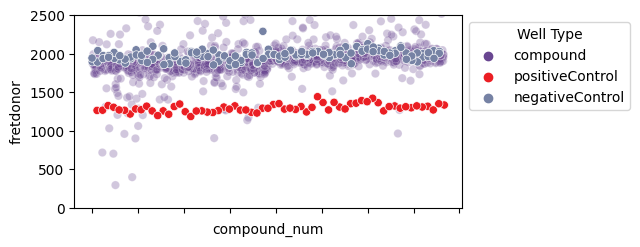

In [100]:
fig, ax = plt.subplots(1, figsize=(5,2.5))
# ax.scatter(data=nuc[nuc['Well Type']=='compound'], x='Compound', y='fretdonor', label='compound', zorder=0, s=5, c=colors[0])
# ax.scatter(data=nuc[nuc['Well Type']=='positiveControl'], x='Compound', y='fretdonor', label='posctrl', zorder=1, s=5, c=colors[1])
# ax.scatter(data=nuc[nuc['Well Type']=='negativeControl'], x='index', y='fretdonor', label='negctrl', zorder=2, s=5, c=colors[2])
sns.scatterplot(nuc[nuc['Well Type']!='compound'], x='compound_num', y='fretdonor', hue='Well Type', palette=colors[3:])
sns.scatterplot(nuc[nuc['Well Type']=='compound'], x='compound_num', y='fretdonor', hue='Well Type', palette=colors[3:], zorder=0, alpha=0.3)
handles, labels=ax.get_legend_handles_labels()
labels=labels[3:]
handles=handles[3:]
ax.legend(handles, labels,title='Well Type')
ax.set_ylim(0,2500)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.set_xticklabels('');

In [97]:
for label in labels:
    print(label)

compound
positiveControl
negativeControl
compound
positiveControl
negativeControl


In [102]:
nuc[nuc['Well Type']=='compound'].fretdonor.std()*3

5584.371641799041